In [1]:
import xarray as xr
import datetime
import pymannkendall as mk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load landcover and anette's landcover! (first normal landcover)
land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc', engine='netcdf4')

In [3]:
lc = land_cover.sel(lat=slice(72,55), lon=slice(-168,-150))

In [4]:
metop = xr.open_dataset('standard_anomalies_alaska_day_metop.nc')

In [5]:
lc_interp = lc.interp(lat=metop.coords['lat'], lon=metop.coords['lon'], method='nearest')

In [6]:
subset = metop.sel(lat=slice(55,72), lon=slice(-168,-150), time=slice('1982', '2018'))

In [7]:
subset = subset.where(lc_interp['lccs_class'] != 210)

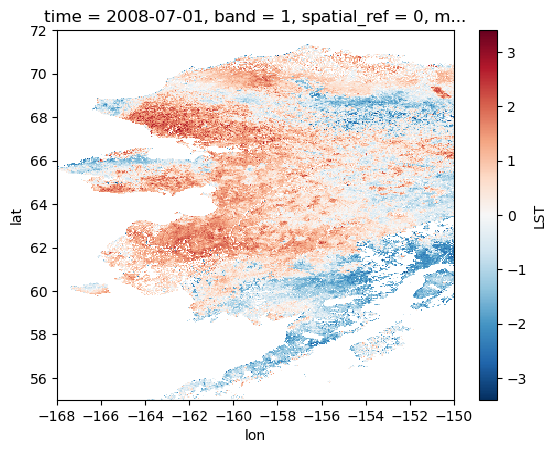

In [15]:
subset['LST'].isel(time=13).plot();

In [16]:
subset

<xarray.Dataset>
Dimensions:      (lat: 340, lon: 360, time: 139)
Coordinates:
  * lat          (lat) float32 55.03 55.08 55.12 55.17 ... 71.88 71.93 71.97
  * lon          (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.1 -150.0
  * time         (time) datetime64[ns] 2007-06-01 2007-07-01 ... 2018-12-01
    band         int64 1
    spatial_ref  int64 0
    month        (time) int64 ...
Data variables:
    LST          (lat, lon, time) float32 nan nan nan nan ... nan nan nan nan

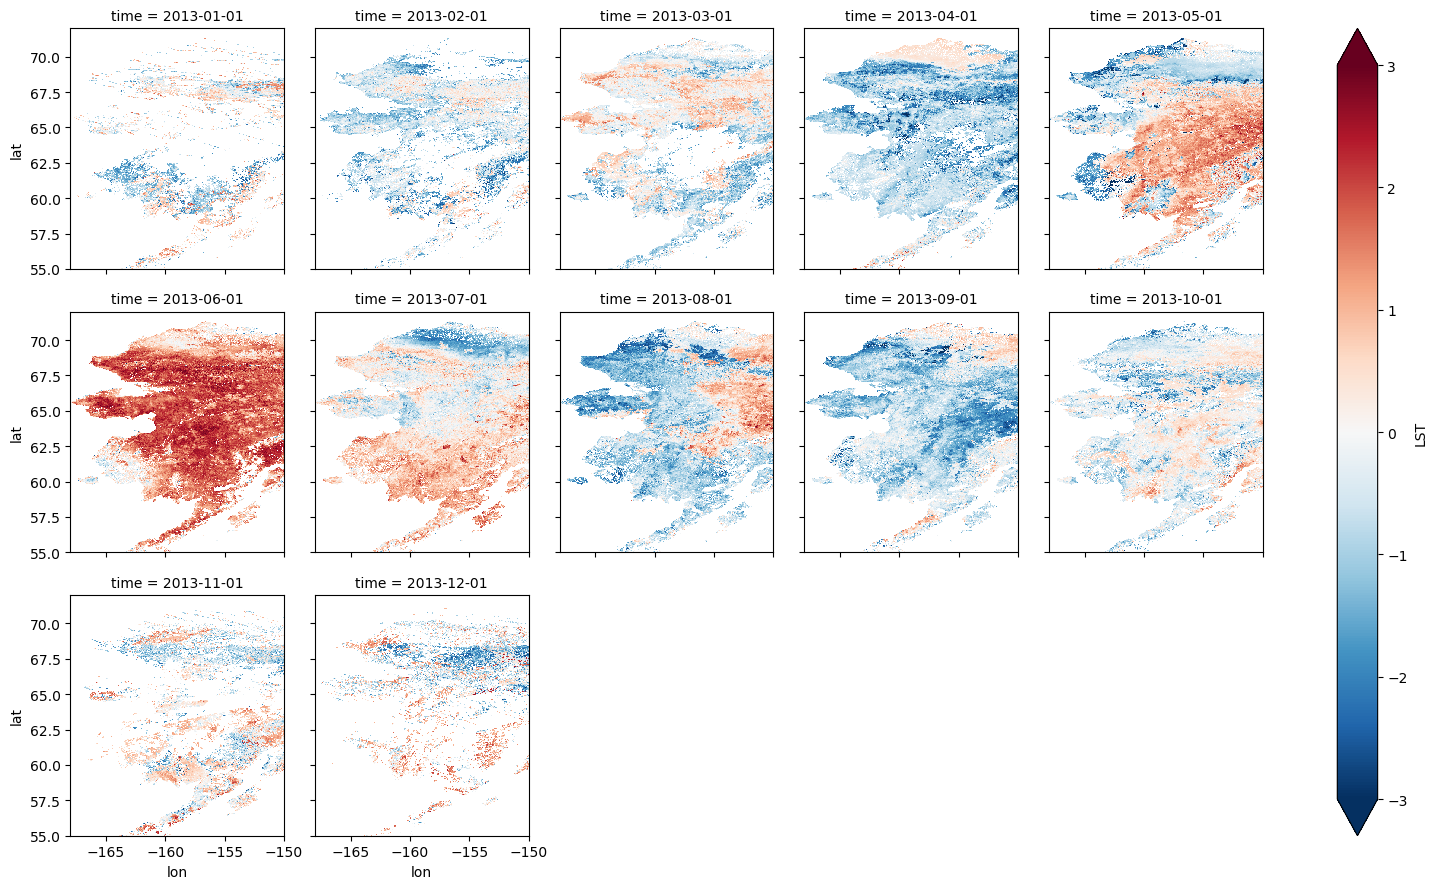

In [43]:
subset['LST'].sel(lat=slice(55,72), lon=slice(-168,-150), time=slice('2013-01','2013-12')).plot(x="lon", y="lat", col="time", col_wrap=5, vmax=3);

In [ ]:
# swath line issues ? in earlier satellites ? cannot work with monthly max data ? do that based on observation time ? 

In [20]:
n_valid = subset['LST'].count(dim="time")

In [21]:
n_valid = n_valid.where(lc_interp['lccs_class'] != 210)

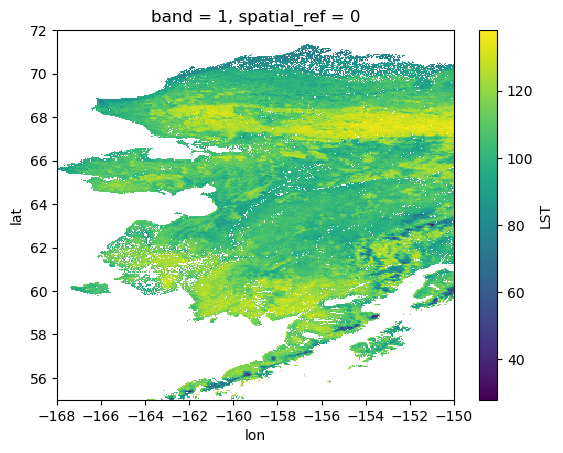

In [22]:
n_valid.plot()

In [23]:
above = ((subset['LST'] > 0) & (subset['LST'] < 3.0)).sum(dim="time")
below = ((subset['LST'] < 0) & (subset['LST'] > -3.0)).sum(dim="time")

In [24]:
below = below.where((lc_interp['lccs_class'] != 210) & (below!=0))
above = above.where((lc_interp['lccs_class'] != 210) & (above!=0))

In [63]:
above_1 = ((subset['LST'] > 1) & (subset['LST'] < 3.0)).sum(dim="time")
below_minus1 = ((subset['LST'] < -1) & (subset['LST'] > -3.0)).sum(dim="time")

In [64]:
below_minus1 = below_minus1.where((lc_interp['lccs_class'] != 210) & (below_minus1!=0))

In [60]:
above_1 = above_1.where((lc_interp['lccs_class'] != 210) & (above_1!=0))

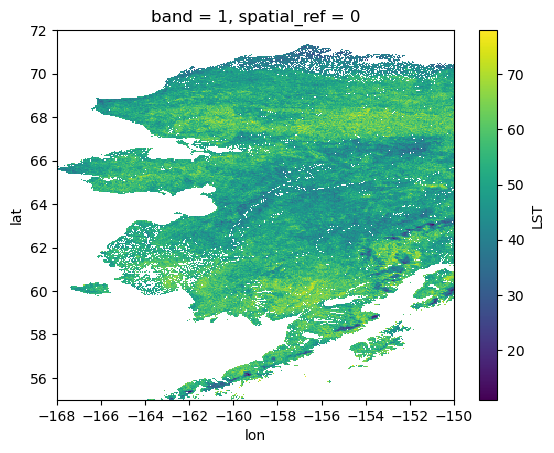

In [28]:
below.plot()

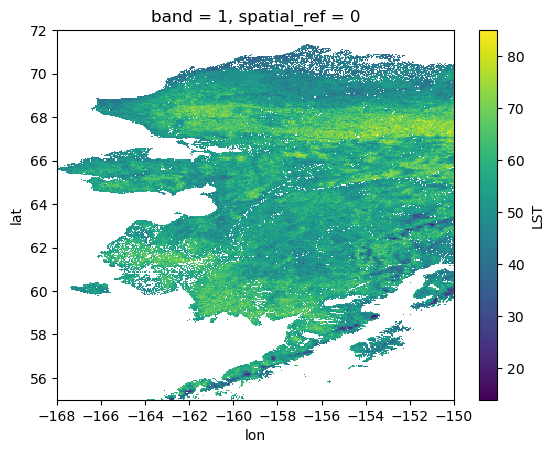

In [29]:
above.plot();

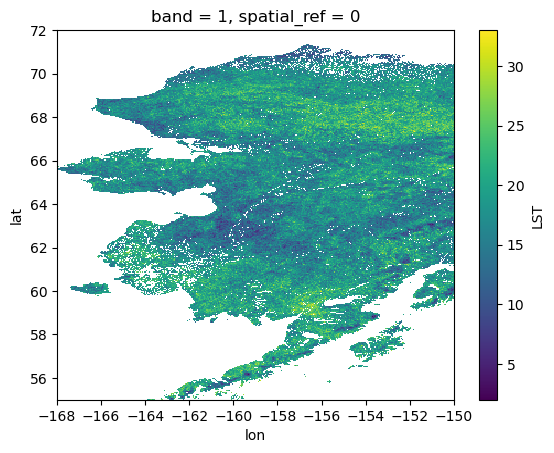

In [65]:
# anomalies above one
below_minus1.plot();

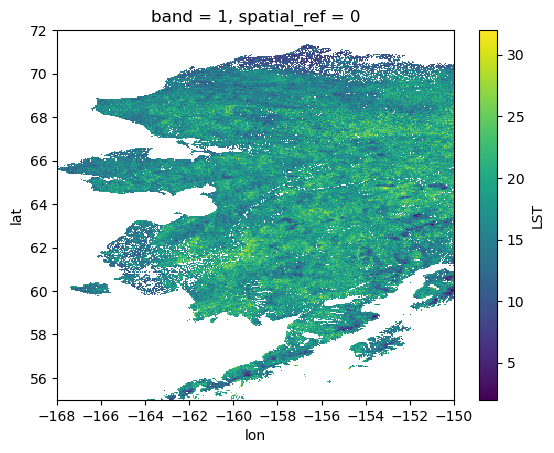

In [61]:
above_1.plot()

In [33]:
lst= subset['LST']

In [36]:
valid_pixels = lst.count(dim=("lat", "lon"))
above_1 = ((lst > 1 )& (lst<3)).sum(dim=("lat", "lon"))
prop_above_1 = above_1 / valid_pixels

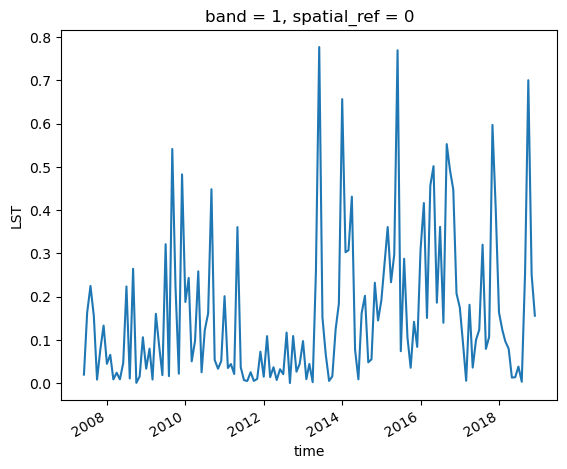

In [37]:
prop_above_1.plot();

In [38]:
import pymannkendall as mk

ts = prop_above_1.dropna(dim="time").values

In [39]:
result = mk.original_test(ts)

In [40]:
result

Mann_Kendall_Test(trend='increasing', h=True, p=0.0007257338939330449, z=3.3796681842263214, Tau=0.1936190178292149, s=1857.0, var_s=301583.6666666667, slope=0.0007642709104990191, intercept=0.053194687588625646)

In [ ]:
# link to land cover

In [44]:
import xarray as xr
import numpy as np

time_numeric = np.arange(len(ts))
trend_line = result.intercept + result.slope * time_numeric

In [45]:
trend_da = xr.DataArray(
    trend_line,
    coords={"time": prop_above_1.dropna(dim="time").time},
    dims="time",
    name="theil_sen_trend"
)

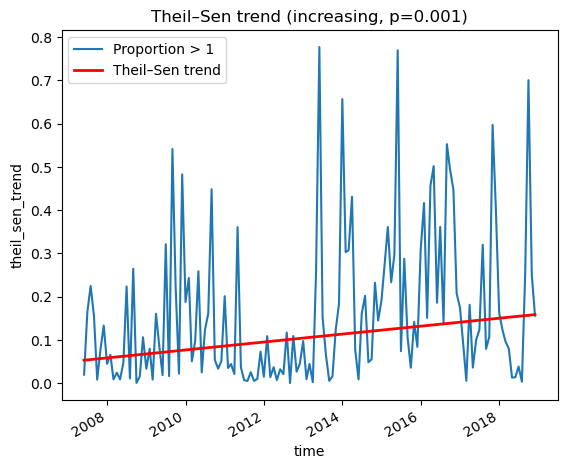

In [46]:
import matplotlib.pyplot as plt

prop_above_1.plot(label="Proportion > 1")
trend_da.plot(color="red", linewidth=2, label="Theil–Sen trend")

plt.legend()
plt.title(
    f"Theil–Sen trend ({result.trend}, p={result.p:.3f})"
)
plt.show()


In [ ]:
# focus on the mountain zone? that has less clouds ? 

In [47]:
# link to land cover and SWE
def map_landcover(df):

    lc_group_map = {
    # 1. Agriculture
    10: "Crop",
    11: "Crop",
    20: "Crop",
    30: "Crop",
    40: "Crop",

    # 2. Forest
    50: "EBF",
    60: "DBF", 61: "DBF", 62: "DBF",
    70: "ENF", 71: "ENF", 72: "ENF",
    80: "DNF", 81: "DNF", 82: "DNF",
    90: "MF",
    100: "MF",
    160: "FF",
    170: "FF",

    # 3. Grassland
    110: "Grass",
    130: "Grass",

    # 4. Wetland
    180: "Wet",

    # 5. Settlement
    190: "Settlement",

    # 6. Other (Shrubland / Sparse / Bare / Water)
    120: "Shrub",
    121: "Shrub",
    122: "Shrub",
    140: "Lichens",
    150: "Sparse",
    151: "Sparse",
    152: "Sparse",
    153: "Sparse",
    200: "Bare",
    201: "Bare",
    202: "Bare",
    220: "Ice"
    }

    df["landcover_group"] = df["landcover"].map(lc_group_map)
    # filter classes with very low samples
    counts = df["landcover_group"].value_counts()
    valid_classes = counts[counts > 20].index

    df = df[df["landcover_group"].isin(valid_classes)]
    return df


In [55]:
# link to land cover ? Day and Night -> check with air temperature
def df_creation(ds, lc):
    lc_interp = lc
    data = ds.where(~np.isnan(lc_interp['lccs_class']))
    landcover = lc_interp.where(~np.isnan(ds))
    print(data)
    trend_1d = data.stack(points=("lat", "lon"))
    lc_1d = landcover['lccs_class'].stack(points=("lat", "lon"))

    valid = (~np.isnan(trend_1d)) & (~np.isnan(lc_1d))
    trend_1d = trend_1d[valid]
    lc_1d = lc_1d[valid]
    df = pd.DataFrame({
    "trend": trend_1d.values,
    "landcover": lc_1d.values.astype(int)
    })

    df_filtered = map_landcover(df)
    return df_filtered

In [53]:
lc_interp = lc_interp.sel(lat=slice(55,72), lon=slice(-168,-150))


In [62]:
anom_df_above1_d = df_creation(above_1, lc_interp)

<xarray.DataArray 'LST' (lat: 340, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat          (lat) float32 55.03 55.08 55.12 55.17 ... 71.88 71.93 71.97
  * lon          (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.1 -150.0
    band         int64 1
    spatial_ref  int64 0


In [66]:
anom_df_below_d = df_creation(below_minus1, lc_interp)

<xarray.DataArray 'LST' (lat: 340, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat          (lat) float32 55.03 55.08 55.12 55.17 ... 71.88 71.93 71.97
  * lon          (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.1 -150.0
    band         int64 1
    spatial_ref  int64 0


In [67]:
result_anoms_alaska = (
    pd.concat(
        [anom_df_above1_d, anom_df_below_d],
        keys=["Day_positive", "Day_negative"],
        names=["Datasets"]
    )
    .reset_index(level="Datasets")
)

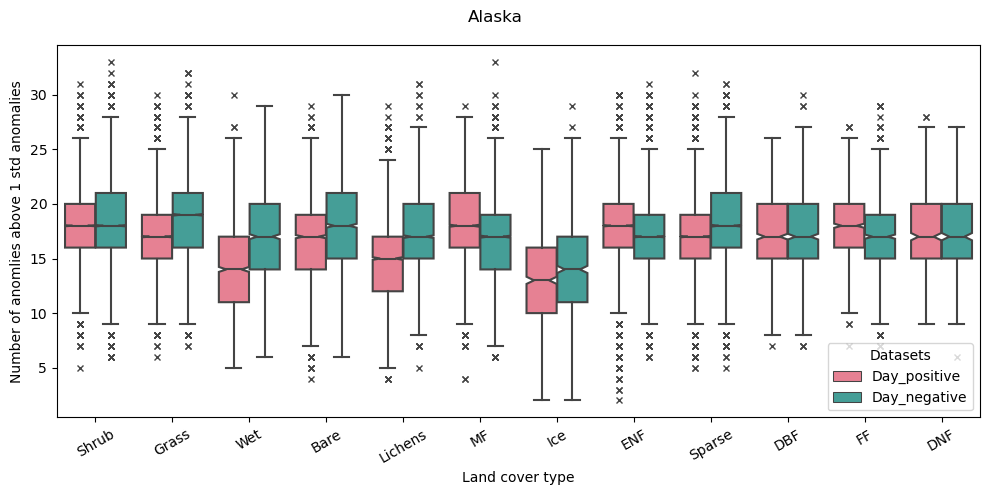

In [69]:
# Group all boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=result_anoms_alaska,
    x="landcover_group",   # or "landcover"
    y="trend",
    hue='Datasets',
    palette = 'husl',
    notch=True,
    flierprops={"marker":"x"}
)

plt.ylabel("Number of anomlies above 1 std anomalies")
plt.xlabel("Land cover type")
plt.suptitle('Alaska')
plt.xticks(rotation=30)
plt.tight_layout()
#plt.savefig('Alaska_box_plot_anomalies.png')
plt.show()